# Classification Modeling

In [1]:
import classifiers as clf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

import pickle

### Load Species Data

In [2]:
species = pd.read_pickle("../Data/species.pkl")
species.head()

,Scientific Name,Common Name,Federal Listing Status,Group_Amphibians,Group_Birds,Group_Clams,Group_Crustaceans,Group_Ferns and Allies,Group_Fishes,Group_Flowering Plants,...,State_OR,State_PA,State_SC,State_TN,State_TX,State_UT,State_VA,State_WA,State_WV,State_WY
0,Accipiter gentilis,Northern goshawk,Not Listed,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acipenser fulvescens,Lake sturgeon,Not Listed,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Acipenser oxyrinchus (=oxyrhynchus) desotoi,Atlantic sturgeon (Gulf subspecies),Threatened,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Agarodes alabamensis,[Unnamed] caddisfly,Not Listed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Agrimonia incisa,Incised groovebur,Not Listed,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Set Target and Feature Variables

In [3]:
# Create target and feature variables
y = species['Federal Listing Status']
X = species.drop(['Federal Listing Status', 'Scientific Name', 'Common Name'], axis = 1)

### Create Training and Test Sets

In [4]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# federal listing status
print('Training Data: ' + str(y_train.count()))
print('Endangered:    ' + str((y_train == 'Endangered').sum() / y_train.count()))
print('Not Listed:    ' + str((y_train == 'Not Listed').sum() / y_train.count()))
print('Threatened:    ' + str((y_train == 'Threatened').sum() / y_train.count()))

# federal listing status
print('Test Data:     ' + str(y_test.count()))
print('Endangered:    ' + str((y_test == 'Endangered').sum() / y_test.count()))
print('Not Listed:    ' + str((y_test == 'Not Listed').sum() / y_test.count()))
print('Threatened:    ' + str((y_test == 'Threatened').sum() / y_test.count()))

Training Data: 9389
Endangered:    0.15912237724997338
Not Listed:    0.7713281499627224
Threatened:    0.06954947278730429
Test Data:     2348
Endangered:    0.17248722316865417
Not Listed:    0.7657580919931857
Threatened:    0.061754684838160136


### Baseline Classification Model Parameters

In [5]:
# list for all classifiers
classifiers = []

# dummy classifier
classifiers.append({'Model': 'Dummy',
                    'Classifier': DummyClassifier(strategy='most_frequent')})

# logistic regression classifer
classifiers.append({'Model': 'Logistic Regression',
                    'Classifier': LogisticRegression(C=1e12,
                                                     penalty='l1',
                                                     multi_class='ovr',
                                                     solver='liblinear',
                                                     n_jobs=-1)})

# k nearest neighbors classifer
classifiers.append({'Model': 'K Nearest Neighbors',
                    'Classifier': KNeighborsClassifier(n_neighbors=5)})

# decision tree classifer
classifiers.append({'Model': 'Decision Tree',
                    'Classifier': DecisionTreeClassifier(criterion='gini',
                                                         max_depth=9,
                                                         max_features=0.9)})

# random forest classifer
classifiers.append({'Model': 'Random Forest',
                    'Classifier': RandomForestClassifier(n_estimators=100,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=0.6)})

In [6]:
classifiers, metrics = clf.classify(classifiers, X_train, X_test, y_train, y_test)

baseline = pd.DataFrame(metrics, columns=['Model',
                                          'Split',
                                          'Accuracy',
                                          'Precision',
                                          'Recall',
                                          'F1 Score'])
baseline['Configuration'] = 'Baseline'
models = baseline.copy()
models

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

,Model,Split,Accuracy,Precision,Recall,F1 Score,Configuration
0,Dummy,Train,0.771328,0.594947,0.771328,0.671753,Baseline
1,Dummy,Test,0.765758,0.586385,0.765758,0.664174,Baseline
2,Logistic Regression,Train,0.796464,0.766187,0.796464,0.735703,Baseline
3,Logistic Regression,Test,0.783220,0.750656,0.783220,0.716853,Baseline
4,K Nearest Neighbors,Train,0.791565,0.744817,0.791565,0.750783,Baseline
5,K Nearest Neighbors,Test,0.772572,0.711545,0.772572,0.724651,Baseline
6,Decision Tree,Train,0.798914,0.762437,0.798914,0.740189,Baseline
7,Decision Tree,Test,0.781942,0.716912,0.781942,0.716481,Baseline
8,Random Forest,Train,0.797636,0.732705,0.797636,0.737209,Baseline
9,Random Forest,Test,0.784072,0.721303,0.784072,0.718403,Baseline


In [7]:
baseline.pivot(index='Model', columns='Split').drop(
    'Configuration', axis=1).sort_values(by=('F1 Score','Train'), ascending=False)

Accuracy           Precision              Recall  \
Split                    Test     Train      Test     Train      Test   
Model                                                                   
K Nearest Neighbors  0.772572  0.791565  0.711545  0.744817  0.772572   
Decision Tree        0.781942  0.798914  0.716912  0.762437  0.781942   
Random Forest        0.784072  0.797636  0.721303  0.732705  0.784072   
Logistic Regression  0.783220  0.796464  0.750656  0.766187  0.783220   
Dummy                0.765758  0.771328  0.586385  0.594947  0.765758   

                               F1 Score            
Split                   Train      Test     Train  
Model                                              
K Nearest Neighbors  0.791565  0.724651  0.750783  
Decision Tree        0.798914  0.716481  0.740189  
Random Forest        0.797636  0.718403  0.737209  
Logistic Regression  0.796464  0.716853  0.735703  
Dummy                0.771328  0.664174  0.671753

### Handling Class Imbalance with SMOTE Oversampling

9389
Endangered: 0.15912237724997338
Not Listed: 0.7713281499627224
Threatened: 0.06954947278730429


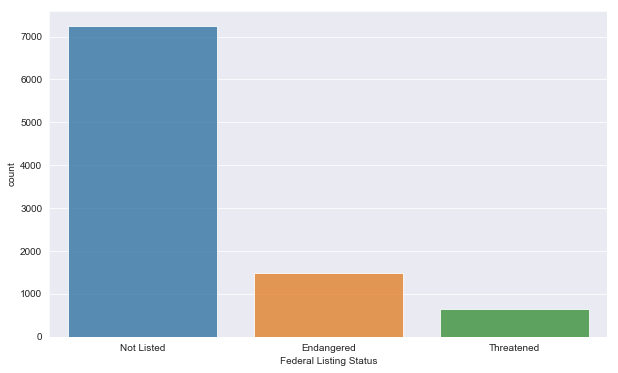

In [8]:
# federal listing status
print(y_train.count())
print('Endangered: ' + str((y_train == 'Endangered').sum() / y_train.count()))
print('Not Listed: ' + str((y_train == 'Not Listed').sum() / y_train.count()))
print('Threatened: ' + str((y_train == 'Threatened').sum() / y_train.count()))

# plot class imbalance
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_train,
              order=y_train.value_counts().index,
              alpha=0.8)

In [9]:
keys = list(y_train.unique())
values = np.ones((3), dtype=int) * (y_train == 'Not Listed').sum()
sample_ratio = dict(zip(keys, values))
sample_ratio

{'Not Listed': 7242, 'Endangered': 7242, 'Threatened': 7242}

21726
Endangered: 0.3333333333333333
Not Listed: 0.3333333333333333
Threatened: 0.3333333333333333


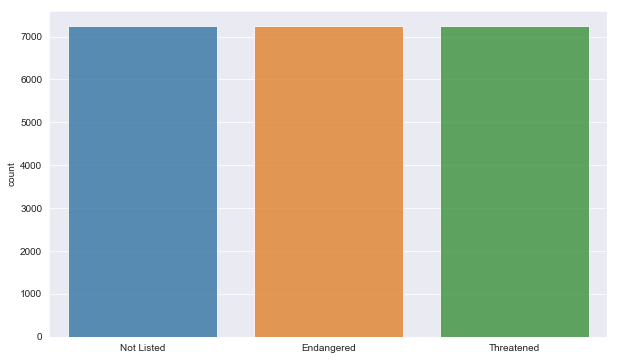

In [10]:
species['Federal Listing Status'].unique()

smote = SMOTE(ratio=sample_ratio)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

# federal listing status
print(len(y_train_smote))
print('Endangered: ' + str((y_train_smote == 'Endangered').sum() / len(y_train_smote)))
print('Not Listed: ' + str((y_train_smote == 'Not Listed').sum() / len(y_train_smote)))
print('Threatened: ' + str((y_train_smote == 'Threatened').sum() / len(y_train_smote)))

# plot class imbalance
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_train_smote,
              order=y_train.value_counts().index,
              alpha=0.8)

### Balanced Classification Models

In [11]:
classifiers, metrics = clf.classify(classifiers, X_train_smote, X_test, y_train_smote, y_test)

balanced = pd.DataFrame(metrics, columns=['Model',
                                          'Split',
                                          'Accuracy',
                                          'Precision',
                                          'Recall',
                                          'F1 Score'])

balanced['Configuration'] = 'Balanced'
models = models.append(balanced, ignore_index=True)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

In [12]:
models.sort_values(by='F1 Score', ascending=False)

,Model,Split,Accuracy,Precision,Recall,F1 Score,Configuration
4,K Nearest Neighbors,Train,0.791565,0.744817,0.791565,0.750783,Baseline
6,Decision Tree,Train,0.798914,0.762437,0.798914,0.740189,Baseline
8,Random Forest,Train,0.797636,0.732705,0.797636,0.737209,Baseline
2,Logistic Regression,Train,0.796464,0.766187,0.796464,0.735703,Baseline
15,K Nearest Neighbors,Test,0.749574,0.716742,0.749574,0.729559,Balanced
5,K Nearest Neighbors,Test,0.772572,0.711545,0.772572,0.724651,Baseline
9,Random Forest,Test,0.784072,0.721303,0.784072,0.718403,Baseline
3,Logistic Regression,Test,0.783220,0.750656,0.783220,0.716853,Baseline
7,Decision Tree,Test,0.781942,0.716912,0.781942,0.716481,Baseline
19,Random Forest,Test,0.665673,0.753091,0.665673,0.699644,Balanced


In [13]:
balanced.pivot(index='Model', columns='Split').drop(
    'Configuration', axis=1).sort_values(by=('F1 Score','Train'), ascending=False)

Accuracy           Precision              Recall  \
Split                    Test     Train      Test     Train      Test   
Model                                                                   
Decision Tree        0.663969  0.576084  0.747829  0.597252  0.663969   
Random Forest        0.665673  0.561769  0.753091  0.598346  0.665673   
Logistic Regression  0.642249  0.553945  0.727108  0.579135  0.642249   
K Nearest Neighbors  0.749574  0.498527  0.716742  0.597800  0.749574   
Dummy                0.172487  0.333333  0.029752  0.111111  0.172487   

                               F1 Score            
Split                   Train      Test     Train  
Model                                              
Decision Tree        0.576084  0.697817  0.574163  
Random Forest        0.561769  0.699644  0.558258  
Logistic Regression  0.553945  0.676693  0.549864  
K Nearest Neighbors  0.498527  0.729559  0.426996  
Dummy                0.333333  0.050750  0.166667

### Tuned and Balanced Grid Search Classification Models

In [14]:
# list for all grid searches
grid_searches = []

In [15]:
# logistic regression parameters
parameters_log = dict(penalty=['l1', 'l2'],
                      C=[1e-2, 1e0, 1e2, 1e6, 1e12],
                      fit_intercept=[True, False],
                      multi_class=['ovr'],
                      solver=['liblinear'])

grid_searches.append({'Model': 'Logistic Regression',
                    'Classifier': GridSearchCV(LogisticRegression(),
                                               parameters_log,
                                               cv=5,
                                               scoring='f1_weighted',
                                               verbose=10,
                                               n_jobs=-1)})

# k nearest neighbors parameters
parameters_knn = dict(n_neighbors=[5,11],
                      weights=['uniform', 'distance'],
                      algorithm=['ball_tree','kd_tree'],
                      leaf_size=[100,200])

grid_searches.append({'Model': 'K Nearest Neighbors',
                    'Classifier': GridSearchCV(KNeighborsClassifier(),
                                               parameters_knn,
                                               cv=5,
                                               scoring='f1_weighted',
                                               verbose=10,
                                               n_jobs=-1)})

# decision tree parameters
parameters_tree = dict(criterion=['gini','entropy'],
                       max_depth=[6,8],
                       min_samples_leaf=[20,50,100],
                       max_features=[20,30,40],
                       min_impurity_decrease=[0.01,0.03,0.05])

grid_searches.append({'Model': 'Decision Tree',
                    'Classifier': GridSearchCV(DecisionTreeClassifier(),
                                               parameters_tree,
                                               cv=5,
                                               scoring='f1_weighted',
                                               verbose=10,
                                               n_jobs=-1)})

# random forest parameters
parameters_forest = dict(n_estimators=[100,200,300],
                         max_depth=[2,3,4],
                         min_samples_leaf=[100,200],
                         max_features=[10,20],
                         min_impurity_decrease=[0.01,0.03,0.05])

grid_searches.append({'Model': 'Random Forest',
                    'Classifier': GridSearchCV(RandomForestClassifier(),
                                               parameters_forest,
                                               cv=5,
                                               scoring='f1_weighted',
                                               verbose=10,
                                               n_jobs=-1)})

In [16]:
grid_searches, metrics = clf.grid_search(grid_searches, X_train_smote, X_test, y_train_smote, y_test, X.columns)

tuned = pd.DataFrame(metrics, columns=['Model',
                                       'Split',
                                       'Accuracy',
                                       'Precision',
                                       'Recall',
                                       'F1 Score'])

tuned['Configuration'] = 'Balanced and Tuned'
models = models.append(tuned, ignore_index=True, sort=False)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.0s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 12.3min finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

In [17]:
models.sort_values(by='F1 Score', ascending=False)

,Model,Split,Accuracy,Precision,Recall,F1 Score,Configuration
4,K Nearest Neighbors,Train,0.791565,0.744817,0.791565,0.750783,Baseline
6,Decision Tree,Train,0.798914,0.762437,0.798914,0.740189,Baseline
8,Random Forest,Train,0.797636,0.732705,0.797636,0.737209,Baseline
2,Logistic Regression,Train,0.796464,0.766187,0.796464,0.735703,Baseline
15,K Nearest Neighbors,Test,0.749574,0.716742,0.749574,0.729559,Balanced
23,K Nearest Neighbors,Test,0.745315,0.710109,0.745315,0.725906,Balanced and Tuned
5,K Nearest Neighbors,Test,0.772572,0.711545,0.772572,0.724651,Baseline
9,Random Forest,Test,0.784072,0.721303,0.784072,0.718403,Baseline
3,Logistic Regression,Test,0.783220,0.750656,0.783220,0.716853,Baseline
7,Decision Tree,Test,0.781942,0.716912,0.781942,0.716481,Baseline


In [18]:
tuned.pivot(index='Model', columns='Split').drop(
    'Configuration', axis=1).sort_values(by=('F1 Score','Train'), ascending=False)

Accuracy           Precision              Recall  \
Split                    Test     Train      Test     Train      Test   
Model                                                                   
Decision Tree        0.667802  0.555187  0.752383  0.590608  0.667802   
Logistic Regression  0.641823  0.553714  0.727014  0.578904  0.641823   
Random Forest        0.642249  0.547317  0.737430  0.573744  0.642249   
K Nearest Neighbors  0.745315  0.508653  0.710109  0.639084  0.745315   

                               F1 Score            
Split                   Train      Test     Train  
Model                                              
Decision Tree        0.555187  0.700378  0.550403  
Logistic Regression  0.553714  0.676394  0.549672  
Random Forest        0.547317  0.679452  0.544565  
K Nearest Neighbors  0.508653  0.725906  0.443546

In [25]:
balanced.pivot(index='Model', columns='Split').drop(
    'Configuration', axis=1).sort_values(by=('F1 Score','Train'), ascending=False)

Accuracy           Precision              Recall  \
Split                    Test     Train      Test     Train      Test   
Model                                                                   
Decision Tree        0.663969  0.576084  0.747829  0.597252  0.663969   
Random Forest        0.665673  0.561769  0.753091  0.598346  0.665673   
Logistic Regression  0.642249  0.553945  0.727108  0.579135  0.642249   
K Nearest Neighbors  0.749574  0.498527  0.716742  0.597800  0.749574   
Dummy                0.172487  0.333333  0.029752  0.111111  0.172487   

                               F1 Score            
Split                   Train      Test     Train  
Model                                              
Decision Tree        0.576084  0.697817  0.574163  
Random Forest        0.561769  0.699644  0.558258  
Logistic Regression  0.553945  0.676693  0.549864  
K Nearest Neighbors  0.498527  0.729559  0.426996  
Dummy                0.333333  0.050750  0.166667

In [26]:
baseline.pivot(index='Model', columns='Split').drop(
    'Configuration', axis=1).sort_values(by=('F1 Score','Train'), ascending=False)

Accuracy           Precision              Recall  \
Split                    Test     Train      Test     Train      Test   
Model                                                                   
K Nearest Neighbors  0.772572  0.791565  0.711545  0.744817  0.772572   
Decision Tree        0.781942  0.798914  0.716912  0.762437  0.781942   
Random Forest        0.784072  0.797636  0.721303  0.732705  0.784072   
Logistic Regression  0.783220  0.796464  0.750656  0.766187  0.783220   
Dummy                0.765758  0.771328  0.586385  0.594947  0.765758   

                               F1 Score            
Split                   Train      Test     Train  
Model                                              
K Nearest Neighbors  0.791565  0.724651  0.750783  
Decision Tree        0.798914  0.716481  0.740189  
Random Forest        0.797636  0.718403  0.737209  
Logistic Regression  0.796464  0.716853  0.735703  
Dummy                0.771328  0.664174  0.671753

### Data Loading

In [19]:
models.to_pickle("../Data/models.pkl")
baseline.to_pickle("../Data/baseline.pkl")
balanced.to_pickle("../Data/balanced.pkl")
tuned.to_pickle("../Data/tuned.pkl")

In [20]:
pickle.dump(grid_searches, open( "../Data/grid_searches.pkl", "wb" ))
pickle.dump(metrics, open( "../Data/metrics.pkl", "wb" ))

In [35]:
metrics

[{'Model': 'Logistic Regression',
  'Split': 'Train',
  'Best Parameters': {'C': 1.0,
   'fit_intercept': True,
   'multi_class': 'ovr',
   'penalty': 'l2',
   'solver': 'liblinear'},
  'Best Estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr',
            n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
            tol=0.0001, verbose=0, warm_start=False),
  'Accuracy': 0.5537144435238884,
  'Precision': 0.5789044326544971,
  'Recall': 0.5537144435238884,
  'F1 Score': 0.5496723620385536,
  'Confusion Matrix': array([[3127, 2240, 1875],
         [ 865, 5178, 1199],
         [ 533, 2984, 3725]])},
 {'Model': 'Logistic Regression',
  'Split': 'Test',
  'Best Parameters': {'C': 1.0,
   'fit_intercept': True,
   'multi_class': 'ovr',
   'penalty': 'l2',
   'solver': 'liblinear'},
  'Best Estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr